# Custom kernel (Sliced Wasserstein) to deal with persistent diagram

### Quick summary of the idea

What is touchy with persistent diagram is that they do not live in a Hilbert space, and that the distances used on persistent diagram (such as the bottleneck distance), even though they have nice properties that make them useful on diagrams, cannot be used as such to define a "correct" kernel through the usual pipeline: 

$k(x,y) = \text{exp}\left( - \frac{d(x,y)}{2 \sigma^2} \right )$

where $d$ is the distance.

Thus, the idea here is to construct a "nice" distance $d$ so that the associated kernel is convenient. This distance is the Sliced Wasserstein distance.

The article "Sliced Wasserstein Kernel for Persistence Diagrams" by Carrère, Cuturi and Oudot (2017) gives us an algorithm that can compute an approximated value for the Sliced Wasserstein distance, given two persistent diagrams.

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from random import shuffle
import pandas as pd

Let's define the Sliced Wassertein distance and the Sliced Wasserstein gram matrix. There is an hyperparameter M which is not per se related to the SW distance, but is rather a "precision" parameter for the approximation algorithm.
If M is big, the precision is better but the algorithm takes longer to run.
Usually, M=20 is already quite high, and even something like M=5 gives satisfying results.

In [2]:
# SW distance for two diagrams
def SW_kernel(dgm1, dgm2, M=10):
    vec1 = []
    vec2 = []
    for pt1 in dgm1:
        vec1.append([pt1.birth, pt1.death])
        vec2.append([(pt1.birth+pt1.death)/2.0, (pt1.birth+pt1.death)/2.0])
    for pt2 in dgm2:
        vec2.append([pt2.birth, pt2.death])
        vec1.append([(pt2.birth+pt2.death)/2.0, (pt2.birth+pt2.death)/2.0])
    sw = 0
    theta = -np.pi/2
    s = np.pi/M
    for i in range(M):
        v1 = [np.dot(pt1, [theta, theta]) for pt1 in vec1]
        v2 = [np.dot(pt2, [theta, theta]) for pt2 in vec2]
        v1.sort()
        v2.sort()
        val = np.nan_to_num(np.asarray(v1)-np.asarray(v2))
        sw = sw + s*np.linalg.norm(val, ord=1)
        theta = theta + s
        #print("Run :", i, " and sw =", (1/np.pi)*sw)
    return (1/np.pi)*sw

# SW gram matrix for lists of diagrams
def SW_gram(DGM1, DGM2, M = 10, sigma = 0.1):
    n = len(DGM1)
    m = len(DGM2)
    gram = np.zeros([n,m])
    for i in range(n):
        print("i = ", i)
        for j in range(m):
            if j % 10 == 0:
                print("    j = ", j)
            sw = SW_kernel(DGM1[i], DGM2[j], M=M)
            gram[i,j] = np.exp(-sw / (2* sigma**2))
    return gram

### Toy example

We use the dataset MNIST with a MLP architecture (test accuracy = 0.978) to produce persistent diagrams (dgms).
These dgms are produced for 100 clean examples, 50 adversarial examples (FGSM attack) and 50 noisy examples (gaussian noise) with the following parameters.

- threshold = 15000
- epsilon = 0.02 (very small perturbation)
- noise = 0.02

The dataset can be downloaded here: 

In [3]:
import pickle
file_clean = open("dgm_data/DGM_clean.pickle","rb")
file_adv = open("dgm_data/DGM_adv.pickle","rb")
file_noise = open("dgm_data/DGM_noise.pickle","rb")
DGM = pickle.load(file_clean)
DGM_adv = pickle.load(file_adv)
DGM_noise = pickle.load(file_noise)

from random import shuffle
shuffle(DGM)
ntot = len(DGM)
DGM_train = DGM[:int(0.8*ntot)]
DGM_test = DGM[int(0.8*ntot):]

First we try a OCSVM to classify clean dgms vs adversarial or noisy.
Spoiler: it'n not working pretty well, which is quite weird because there is room for nice results.

In [4]:
# Parameters of the algorithm
    # We choose M=5 because it's quite fast but would be 20 is more precise
    # Do not change to much the scale of sigma
M = 5
sigma = 5*10**(-5)

gram_train = SW_gram(DGM_train, DGM_train, M=M, sigma=sigma)
gram_test = SW_gram(DGM_test, DGM_train, M=M, sigma=sigma)
gram_adv = SW_gram(DGM_adv, DGM_train, M=M, sigma=sigma)
gram_noise = SW_gram(DGM_noise, DGM_train, M=M, sigma=sigma)

i =  0
    j =  0
    j =  10


/Users/t.ricatte/dev/tda_for_adv_robustness/tda_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract


    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  1
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  2
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  3
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  4
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  5
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  6
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  7
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  8
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  9
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  10
  

i =  0
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  1
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  2
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  3
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  4
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  5
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  6
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  7
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  8
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  9
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    

    j =  70
i =  10
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  11
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  12
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  13
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  14
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  15
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  16
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  17
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  18
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
    j =  50
    j =  60
    j =  70
i =  19
    j =  0
    j =  10
    j =  20
    j =  30
    j 

In [5]:
clf = svm.OneClassSVM(kernel = "precomputed", nu=0.2)
clf.fit(gram_train)
pred_train = clf.predict(gram_train)
pred_test = clf.predict(gram_test)
pred_adv = clf.predict(gram_adv)
pred_noise = clf.predict(gram_noise)

In [6]:
# Accuracies
print("Train accuracy:", pred_train[pred_train == 1].size/len(pred_train))
print("Test clean accuracy:", pred_test[pred_test == 1].size/len(pred_test))
print("Test adv accuracy:", pred_adv[pred_adv == -1].size/len(pred_adv))
print("Test noisy accuracy:", pred_noise[pred_noise == -1].size/len(pred_adv))

Train accuracy: 0.8
Test clean accuracy: 0.55
Test adv accuracy: 1.0
Test noisy accuracy: 1.0


The results are not pretty good, but if we plot the distribution of the mean kernel values for each type of input, we can easily see that there is indeed a difference between clean and adversarial or noisy input. So we should be able to correctly classify these dgms.

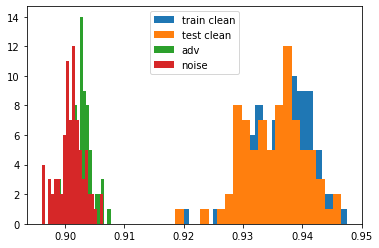

In [7]:
tr = gram_train.mean(0)
te = gram_test.mean(0)
ad = gram_adv.mean(0)
no = gram_noise.mean(0)

plt.hist(tr, bins=20, label = "train clean")
plt.hist(te, bins=20, label="test clean")
plt.hist(ad, bins=20, label = "adv")
plt.hist(no, bins=20, label = "noise")
plt.legend()
plt.show()

Second we try a binary SVM, feeding it with clean and adversarial data (but not with noisy data). It works much better, and even perfectly for now :)

In [30]:
# Preparing data: we train the SVM classifier with 25 clean examples and 25 adversarial examples
DGM_bin_train = DGM_train[:25] + DGM_adv[:25]
DGM_bin_test = DGM_train[25:80] + DGM_adv[25:50] + DGM_noise[0:50]
y_train = np.append(np.repeat(1,25) , np.repeat(-1, 25))
y_test = np.append(np.repeat(1,55), np.repeat(-1, 75))
train_set = pd.DataFrame({'x': DGM_bin_train, 'y': y_train})
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = pd.DataFrame({'x': DGM_bin_test, 'y': y_test})
test_set = test_set.sample(frac=1).reset_index(drop=True)

#clf2 = svm.SVC(C=1, kernel = "precomputed")
#clf2.fit(gram_bin, y_train)
#bin_pred_train = clf2.predict(gram_bin)
#bin_pred_test = clf2.predict(gram_bin_test)

# Accuracy
#sum(bin_pred_train == y_train)/len(bin_pred_train)
#sum(bin_pred_test == y_test)/len(bin_pred_test)

In [46]:
gram_bin = SW_gram(train_set['x'], train_set['x'], M=M, sigma=sigma)
gram_bin_test = SW_gram(test_set['x'], train_set['x'], M=M, sigma=sigma)

i =  0
    j =  0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract


    j =  10
    j =  20
    j =  30
    j =  40
i =  1
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  2
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  3
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  4
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  5
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  6
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  7
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  8
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  9
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  10
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  11
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  12
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  13
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  14
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  15
    j =  0
    

    j =  20
    j =  30
    j =  40
i =  123
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  124
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  125
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  126
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  127
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  128
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40
i =  129
    j =  0
    j =  10
    j =  20
    j =  30
    j =  40


In [47]:
clf2 = svm.SVC(C=1, kernel = "precomputed")
clf2.fit(gram_bin, train_set['y'])
bin_pred_train = clf2.predict(gram_bin)
bin_pred_test = clf2.predict(gram_bin_test)

# Accuracies
print("Accuracy train:", sum(bin_pred_train == train_set['y'])/len(bin_pred_train))
print("Accuracy test:", sum(bin_pred_test == test_set['y'])/len(bin_pred_test))

Accuracy train: 1.0
Accuracy test: 1.0


\o/ !!